# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_027  F5H265            22.098
Sample_062  Q9UHL4            17.932
Sample_008  Q92743            15.828
Sample_148  P27169            20.013
Sample_092  P13611;P13611-5   18.501
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups          
Sample_075  Q9P1W8;Q9P1W8-2;Q9P1W8-4   15.937
Sample_140  Q96MU8;Q96MU8-2;Q96MU8-3   12.116
Sample_153  A6NC48;Q10588;Q10588-2     15.778
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.527
            A0A075B6Q5                 12.333
            A0A075B6R2                 13.431
            A0A075B6S5                 13.670
            A0A087WSY4                 13.580
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   14.752
            Q9UI40;Q9UI40-2            12.027
            Q9UIW2                     12.821
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.131
            Q9UP79                     12.188
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.378,15.050,16.842,19.863,16.136,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.690,19.067,...,15.528,15.576,14.340,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.077,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.201,17.705,17.039,15.919,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.404,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.404,15.345,17.084,18.708,14.249,19.433,11.283,11.027
Sample_207,15.739,16.877,15.469,16.898,14.733,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.527,...,16.012,15.178,14.428,15.050,16.842,19.863,12.417,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.875,19.067,16.188,...,15.528,15.576,13.092,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.289,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.935,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.058,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.712,15.345,17.084,18.708,14.249,19.433,13.388,12.417
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 397.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.74it/s]

100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.95it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.44it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.84it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.76it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.04it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.74it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.07it/s]

100%|██████████| 6/6 [00:02<00:00,  1.91it/s]

100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.86it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.25it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.15it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.05it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.23it/s]

100%|██████████| 7/7 [00:03<00:00,  2.36it/s]

100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.05it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.43it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.91it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.58it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.43it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.31it/s]

100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.56it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.54it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.92it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.96it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.60it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.40it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.25it/s]

100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.89it/s]

 30%|███       | 3/10 [00:01<00:02,  2.84it/s]

 40%|████      | 4/10 [00:01<00:02,  2.82it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.66it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.76it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.55it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.37it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.20it/s]

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.44it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.24it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.10it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.71it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.56it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.54it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.48it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.64it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.81it/s]

100%|██████████| 11/11 [00:03<00:00,  2.55it/s]

100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.95it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.12it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.88it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.79it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.80it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.74it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.52it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.30it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.09it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.03it/s]

100%|██████████| 12/12 [00:04<00:00,  2.11it/s]

100%|██████████| 12/12 [00:04<00:00,  2.42it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.33it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.95it/s]

 31%|███       | 4/13 [00:01<00:03,  2.33it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.12it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.03it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.09it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.20it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.31it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.41it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.42it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.50it/s]

100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

100%|██████████| 13/13 [00:05<00:00,  2.42it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.70it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.01it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.80it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.57it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.43it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.52it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.56it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.59it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.84it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.82it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.88it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.00it/s]

100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.95it/s]

 20%|██        | 3/15 [00:00<00:03,  3.75it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.47it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.91it/s]

 40%|████      | 6/15 [00:01<00:03,  2.96it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.80it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.90it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.08it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.10it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.12it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.15it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.97it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.59it/s]

100%|██████████| 15/15 [00:05<00:00,  2.43it/s]

100%|██████████| 15/15 [00:05<00:00,  2.91it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.059 0.018          0.683 0.404       0.104   
2             0.004 0.002      0.052 0.016          0.695 0.112       0.599   
3             0.005 0.003      0.051 0.014          0.749 0.101       0.710   
4             0.005 0.004      0.062 0.023          0.725 0.107       0.684   
5             0.008 0.006      0.076 0.023          0.732 0.103       0.709   
6             0.004 0.002      0.052 0.015          0.744 0.103       0.717   
7             0.007 0.006      0.068 0.026          0.737 0.102       0.718   
8             0.007 0.005      0.074 0.030          0.741 0.099       0.723   
9             0.005 0.004      0.065 0.029          0.739 0.099       0.712   
10            0.006 0.004      0.071 0.024          0.791 0.091       0.773   
11            0.005 0.004      0.070 0.029          0.788 0.095       0.770   
12            0.005 0.004      0.053 0.016          0.792 0.084       0.785   
13            0.005 0.004      0.062 0.023          0.793 0.084       0.795   
14            0.007 0.005      0.074 0.027          0.791 0.081       0.790   
15            0.007 0.006      0.080 0.028          0.791 0.083       0.792   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.174 0.136                  0.544 0.043        0.854   
2          0.114   0.634 0.088                  0.699 0.063        0.768   
3          0.108   0.723 0.084                  0.765 0.070        0.845   
4          0.094   0.698 0.080                  0.743 0.068        0.840   
5          0.127   0.713 0.091                  0.756 0.075        0.846   
6          0.116   0.724 0.086                  0.766 0.072        0.849   
7          0.116   0.722 0.087                  0.763 0.073        0.846   
8          0.116   0.726 0.088                  0.766 0.073        0.846   
9          0.120   0.720 0.088                  0.762 0.074        0.845   
10         0.106   0.777 0.079                  0.810 0.066        0.895   
11         0.121   0.774 0.089                  0.808 0.074        0.896   
12         0.109   0.785 0.081                  0.816 0.068        0.907   
13         0.103   0.791 0.077                  0.821 0.066        0.908   
14         0.106   0.787 0.077                  0.818 0.065        0.906   
15         0.107   0.788 0.079                  0.819 0.067        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.825 0.093        210.000 0.000  
2          0.073                  0.724 0.098        210.000 0.000  
3          0.069                  0.807 0.092        210.000 0.000  
4          0.071                  0.806 0.090        210.000 0.000  
5          0.067                  0.812 0.083        210.000 0.000  
6          0.068                  0.817 0.086        210.000 0.000  
7          0.067                  0.813 0.084        210.000 0.000  
8          0.067                  0.813 0.085        210.000 0.000  
9          0.066                  0.811 0.084        210.000 0.000  
10         0.052                  0.872 0.058        210.000 0.000  
11         0.053                  0.875 0.060        210.000 0.000  
12         0.051                  0.892 0.055        210.000 0.000  
13         0.050                  0.898 0.051        210.000 0.000  
14         0.050                  0.896 0.052        210.000 0.000  
15         0.051                  0.894 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 453.34it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.51it/s]

100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.81it/s]

100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.68it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.03it/s]

100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.93it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.66it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.38it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.95it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.47it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.98it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.83it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]

100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.57it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.22it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.81it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.66it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  1.96it/s]

100%|██████████| 8/8 [00:03<00:00,  1.78it/s]

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.70it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.36it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.44it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.04it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.92it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.98it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.07it/s]

100%|██████████| 9/9 [00:04<00:00,  2.11it/s]

100%|██████████| 9/9 [00:04<00:00,  2.25it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.86it/s]

 30%|███       | 3/10 [00:01<00:03,  2.11it/s]

 40%|████      | 4/10 [00:01<00:03,  1.97it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.12it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.12it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.23it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.22it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.31it/s]

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.58it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.28it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.81it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.60it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.53it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.47it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.48it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.61it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.51it/s]

100%|██████████| 11/11 [00:04<00:00,  2.54it/s]

100%|██████████| 11/11 [00:04<00:00,  2.66it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.49it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.78it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.70it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.70it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.71it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.71it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.54it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.64it/s]

100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.91it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.61it/s]

 31%|███       | 4/13 [00:01<00:02,  3.20it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.78it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.60it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.68it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.72it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.38it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.44it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.46it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.49it/s]

100%|██████████| 13/13 [00:04<00:00,  2.52it/s]

100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.78it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.29it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.93it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.89it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.88it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.54it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.50it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.50it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.51it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.51it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.47it/s]

100%|██████████| 14/14 [00:05<00:00,  2.16it/s]

100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.63it/s]

 20%|██        | 3/15 [00:00<00:03,  3.73it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.33it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.16it/s]

 40%|████      | 6/15 [00:01<00:03,  2.74it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.66it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.66it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.67it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.67it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.75it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.29it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.09it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  1.97it/s]

100%|██████████| 15/15 [00:06<00:00,  1.99it/s]

100%|██████████| 15/15 [00:06<00:00,  2.48it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.051 0.009          0.063 0.226       0.006   
2             0.005 0.005      0.065 0.029          0.694 0.099       0.506   
3             0.007 0.005      0.080 0.038          0.694 0.103       0.512   
4             0.004 0.002      0.049 0.007          0.691 0.101       0.518   
5             0.004 0.002      0.045 0.015          0.761 0.089       0.620   
6             0.007 0.005      0.087 0.038          0.746 0.089       0.621   
7             0.006 0.004      0.065 0.022          0.781 0.106       0.739   
8             0.005 0.004      0.058 0.022          0.780 0.106       0.741   
9             0.004 0.001      0.050 0.011          0.817 0.100       0.777   
10            0.004 0.001      0.050 0.009          0.809 0.099       0.755   
11            0.005 0.004      0.058 0.018          0.808 0.101       0.779   
12            0.004 0.002      0.056 0.019          0.808 0.098       0.782   
13            0.006 0.004      0.064 0.023          0.838 0.092       0.795   
14            0.005 0.004      0.064 0.026          0.843 0.093       0.807   
15            0.007 0.007      0.066 0.027          0.843 0.092       0.803   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.021   0.011 0.038                  0.499 0.012        0.866   
2          0.113   0.577 0.090                  0.670 0.054        0.718   
3          0.114   0.581 0.091                  0.671 0.055        0.710   
4          0.116   0.584 0.090                  0.673 0.055        0.706   
5          0.111   0.677 0.080                  0.737 0.056        0.808   
6          0.114   0.672 0.085                  0.733 0.059        0.805   
7          0.123   0.752 0.088                  0.791 0.071        0.892   
8          0.123   0.753 0.087                  0.792 0.070        0.891   
9          0.104   0.789 0.069                  0.821 0.055        0.910   
10         0.110   0.774 0.080                  0.809 0.064        0.908   
11         0.110   0.785 0.074                  0.818 0.060        0.913   
12         0.115   0.787 0.076                  0.820 0.062        0.914   
13         0.112   0.810 0.079                  0.839 0.064        0.922   
14         0.112   0.819 0.078                  0.847 0.064        0.923   
15         0.109   0.817 0.078                  0.845 0.063        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.834 0.088        210.000 0.000  
2          0.071                  0.702 0.073        210.000 0.000  
3          0.070                  0.689 0.072        210.000 0.000  
4          0.072                  0.683 0.073        210.000 0.000  
5          0.067                  0.771 0.091        210.000 0.000  
6          0.067                  0.767 0.090        210.000 0.000  
7          0.053                  0.866 0.069        210.000 0.000  
8          0.053                  0.864 0.069        210.000 0.000  
9          0.046                  0.882 0.063        210.000 0.000  
10         0.048                  0.881 0.064        210.000 0.000  
11         0.047                  0.883 0.066        210.000 0.000  
12         0.047                  0.883 0.069        210.000 0.000  
13         0.045                  0.898 0.061        210.000 0.000  
14         0.045                  0.901 0.058        210.000 0.000  
15         0.044                  0.901 0.057 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 937.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 16.47it/s]

100%|██████████| 2/2 [00:00<00:00, 14.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.76it/s]

100%|██████████| 3/3 [00:00<00:00, 10.16it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.68it/s]

100%|██████████| 4/4 [00:00<00:00, 11.15it/s]

100%|██████████| 4/4 [00:00<00:00, 11.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 17.88it/s]

 80%|████████  | 4/5 [00:00<00:00,  8.97it/s]

100%|██████████| 5/5 [00:00<00:00,  9.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.76it/s]

100%|██████████| 6/6 [00:00<00:00, 12.06it/s]

100%|██████████| 6/6 [00:00<00:00, 12.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.03it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.89it/s]

100%|██████████| 7/7 [00:00<00:00, 12.50it/s]

100%|██████████| 7/7 [00:00<00:00, 13.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 24.92it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.36it/s]

100%|██████████| 8/8 [00:00<00:00, 17.56it/s]

100%|██████████| 8/8 [00:00<00:00, 18.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.26it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.52it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.79it/s]

100%|██████████| 9/9 [00:00<00:00, 13.54it/s]

100%|██████████| 9/9 [00:00<00:00, 14.20it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 23.66it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.97it/s]

 90%|█████████ | 9/10 [00:00<00:00, 17.55it/s]

100%|██████████| 10/10 [00:00<00:00, 18.23it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 26.50it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 23.03it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 21.42it/s]

100%|██████████| 11/11 [00:00<00:00, 21.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 29.30it/s]

 50%|█████     | 6/12 [00:00<00:00, 23.43it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 22.70it/s]

100%|██████████| 12/12 [00:00<00:00, 22.04it/s]

100%|██████████| 12/12 [00:00<00:00, 22.71it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 27.70it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 23.68it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 23.01it/s]

100%|██████████| 13/13 [00:00<00:00, 21.58it/s]

100%|██████████| 13/13 [00:00<00:00, 22.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 28.06it/s]

 50%|█████     | 7/14 [00:00<00:00, 24.36it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 23.36it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 21.98it/s]

100%|██████████| 14/14 [00:00<00:00, 22.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 28.03it/s]

 47%|████▋     | 7/15 [00:00<00:00, 22.85it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 20.35it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 20.49it/s]

100%|██████████| 15/15 [00:00<00:00, 21.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.060 0.022          0.000 0.000       0.000   
2             0.007 0.006      0.078 0.033          0.636 0.111       0.463   
3             0.005 0.004      0.061 0.019          0.645 0.106       0.469   
4             0.005 0.003      0.058 0.017          0.661 0.126       0.472   
5             0.007 0.006      0.065 0.026          0.646 0.121       0.464   
6             0.004 0.001      0.047 0.013          0.644 0.122       0.464   
7             0.003 0.001      0.033 0.008          0.645 0.118       0.469   
8             0.004 0.000      0.047 0.007          0.647 0.118       0.465   
9             0.004 0.002      0.047 0.010          0.666 0.109       0.581   
10            0.003 0.002      0.035 0.012          0.658 0.101       0.624   
11            0.003 0.001      0.030 0.007          0.658 0.105       0.611   
12            0.003 0.001      0.030 0.006          0.671 0.105       0.636   
13            0.003 0.001      0.030 0.006          0.671 0.099       0.672   
14            0.003 0.001      0.030 0.006          0.685 0.093       0.654   
15            0.003 0.001      0.032 0.011          0.680 0.092       0.655   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.093   0.528 0.080                  0.630 0.057        0.717   
3          0.104   0.535 0.086                  0.637 0.057        0.713   
4          0.112   0.539 0.095                  0.642 0.064        0.716   
5          0.115   0.529 0.096                  0.634 0.066        0.713   
6          0.114   0.528 0.095                  0.632 0.064        0.707   
7          0.106   0.532 0.081                  0.633 0.055        0.703   
8          0.114   0.529 0.092                  0.635 0.058        0.696   
9          0.107   0.614 0.088                  0.680 0.069        0.767   
10         0.099   0.636 0.081                  0.690 0.069        0.768   
11         0.092   0.628 0.076                  0.685 0.066        0.764   
12         0.101   0.647 0.082                  0.700 0.069        0.778   
13         0.105   0.666 0.084                  0.713 0.073        0.791   
14         0.104   0.664 0.078                  0.715 0.064        0.814   
15         0.104   0.662 0.077                  0.712 0.064        0.811   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.688 0.085        210.000 0.000  
2          0.066                  0.656 0.082        210.000 0.000  
3          0.069                  0.650 0.083        210.000 0.000  
4          0.068                  0.651 0.083        210.000 0.000  
5          0.064                  0.647 0.076        210.000 0.000  
6          0.066                  0.641 0.078        210.000 0.000  
7          0.065                  0.640 0.077        210.000 0.000  
8          0.067                  0.634 0.077        210.000 0.000  
9          0.071                  0.724 0.088        210.000 0.000  
10         0.072                  0.722 0.088        210.000 0.000  
11         0.072                  0.728 0.089        210.000 0.000  
12         0.075                  0.737 0.092        210.000 0.000  
13         0.073                  0.750 0.089        210.000 0.000  
14         0.065                  0.784 0.071        210.000 0.000  
15         0.064                  0.780 0.071 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,15,2
score_time,15,6,2
test_precision,13,14,14
test_recall,13,14,13
test_f1,13,14,13
test_balanced_accuracy,13,14,14
test_roc_auc,13,15,14
test_average_precision,13,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.68it/s]

 20%|██        | 3/15 [00:00<00:02,  5.94it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.23it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.93it/s]

 40%|████      | 6/15 [00:01<00:01,  4.73it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.67it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.57it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.54it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.48it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.97it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.88it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  3.90it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]

100%|██████████| 15/15 [00:03<00:00,  4.06it/s]

100%|██████████| 15/15 [00:03<00:00,  4.43it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 29.31it/s]

 50%|█████     | 7/14 [00:00<00:00, 24.54it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 23.72it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 22.82it/s]

100%|██████████| 14/14 [00:00<00:00, 23.50it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.10it/s]

 31%|███       | 4/13 [00:00<00:01,  5.05it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.80it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.70it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.87it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.87it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.91it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.97it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  5.05it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.88it/s]

100%|██████████| 13/13 [00:02<00:00,  4.99it/s]

100%|██████████| 13/13 [00:02<00:00,  5.04it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


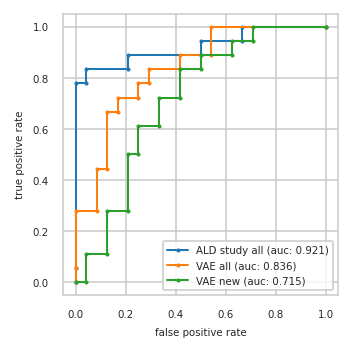

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.778   0.000 0.278   0.042 0.111
3          0.042 0.778   0.083 0.278   0.125 0.111
4          0.042 0.833   0.083 0.444   0.125 0.278
5          0.208 0.833   0.125 0.444   0.208 0.278
6          0.208 0.889   0.125 0.667   0.208 0.500
7          0.500 0.889   0.167 0.667   0.250 0.500
8          0.500 0.944   0.167 0.722   0.250 0.611
9          0.667 0.944   0.250 0.722   0.333 0.611
10         0.667 1.000   0.250 0.778   0.333 0.722
11         1.000 1.000   0.292 0.778   0.417 0.722
12           NaN   NaN   0.292 0.833   0.417 0.833
13           NaN   NaN   0.417 0.833   0.500 0.833
14           NaN   NaN   0.417 0.889   0.500 0.889
15           NaN   NaN   0.542 0.889   0.625 0.889
16           NaN   NaN   0.542 1.000   0.625 0.944
17           NaN   NaN   1.000 1.000   0.708 0.944
18           NaN   NaN     NaN   NaN   0.708 1.000
19           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NBI6,K7ER15;Q9H0R4;Q9H0R4-2,J3KSJ8;Q9UD71;Q9UD71-2
2,P31946;P31946-2,P02741,P51688
3,P04075,P61981,P31321
4,P61981,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
5,C9JF17;P05090,P04075,Q96GD0
6,P14174,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,P25189;P25189-2,Q9Y281;Q9Y281-3
8,P00338;P00338-3,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


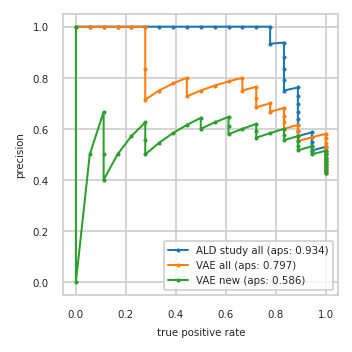

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.552 0.889     0.552 0.889
14         0.571 0.889     0.571 0.889     0.571 0.889
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.600 0.833     0.600 0.833
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.762 0.889     0.667 0.778     0.619 0.722
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.789 0.833     0.684 0.722     0.579 0.611
24         0.833 0.833     0.722 0.722     0.611 0.611
25         0.882 0.833     0.765 0.722     0.647 0.611
26         0.938 0.833     0.750 0.667     0.625 0.556
27         0.933 0.778     0.800 0.667     0.600 0.500
28         1.000 0.778     0.786 0.611     0.643 0.500
29         1.000 0.722     0.769 0.556     0.615 0.444
30         1.000 0.667     0.750 0.500     0.583 0.389
31         1.000 0.611     0.727 0.444     0.545 0.333
32         1.000 0.556     0.800 0.444     0.500 0.278
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.750 0.333     0.625 0.278
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


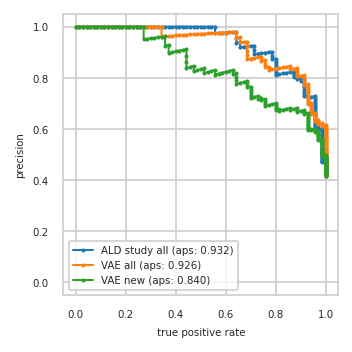

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


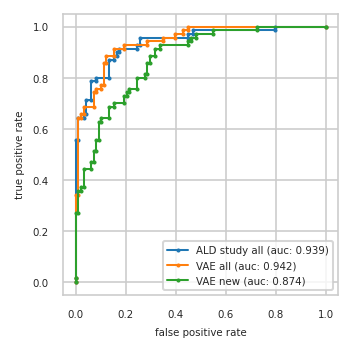

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}